<a href="https://colab.research.google.com/github/ross-hugo/Artwork-GAN/blob/main/notebooks/Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uncomment if runninng on google colab, comment otherwise
!git clone https://github.com/ross-hugo/Artwork-GAN/
%cd Artwork-GAN/

In [1]:
# Uncomment if running locally, comment otherwise
import os
os.chdir("..")
os.getcwd()

'C:\\Users\\Viveca\\Documents\\Elizabeth_Python\\git the 2nd\\Artwork-GAN'

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

import os

# Keras functions
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.layers import Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D, UpSampling2D
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.backend import mean
from math import pi
# Numpy functions
import numpy
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy import ones
from numpy import asarray

from PIL import Image

In [3]:
WIDTH = 128
HEIGHT = 128
IMG_SIZE = (WIDTH,HEIGHT)
SEED_SIZE = 100
IMAGE_CHANNELS = 3
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE=128

In [4]:
class Generator():
  def __init__(self):
    self.model = None
    self.opt = Adam(0.0002,0.5)

  def define_generator_model(self):
    model = tf.keras.Sequential()
    
    model.add(Dense(4*4*512,activation="relu",input_dim=100))
    model.add(Reshape((4,4,512)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))

    model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dropout(0.4))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha =0.3))
    model.add(Dropout(0.4))
    
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False  ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    
    model.add(Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False  ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    
    model.add(Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False  ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=True, activation='tanh'))
    noise = Input(shape=(100,))
    img = model(noise)

    self.model = Model(noise, img)
    return Model(noise, img)

  def generator_loss(self,fake_output):
    cross_entropy = BinaryCrossentropy()
    return cross_entropy(tf.ones_like(fake_output), fake_output)
  
  def generator_opt(self):
    return self.opt

In [5]:
class Discriminator():
  def __init__(self):
    self.model = None
    self.image_shape = (128,128,3)
    self.opt = Adam(0.0002,0.5)
  def define_discriminator_model(self):
    model = tf.keras.Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))


    #block2
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))

    #block3
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2,  padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))

    #block4
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))

    #add ReLU layer
    model.add(LeakyReLU(alpha=0.2))
    
    img = Input(shape=(128, 128, 3))
    features = model(img)
    valid = Dense(1, activation="sigmoid")(features)
    label = Dense(5, activation="softmax")(features)

    self.model = Model(img, [valid, label])
    return Model(img, [valid, label])

  def discriminator_loss(self,real_output, fake_output):
    cross_entropy = BinaryCrossentropy()
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss 
  
  def discriminator_opt(self):
    return self.opt
  
  def discriminator_accuracy(self, real_output, fake_output):
    real_acc = mean(binary_accuracy(tf.ones_like(real_output), real_output))
    fake_acc = mean(binary_accuracy(tf.zeros_like(fake_output), fake_output))

    return real_acc, fake_acc


In [6]:
generator = Generator().define_generator_model()
discriminator = Discriminator().define_discriminator_model()

[<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[0.49999857]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 5), dtype=float32, numpy=
array([[[[0.20000044, 0.20000009, 0.19999972, 0.19999936, 0.2000003 ]]]],
      dtype=float32)>]


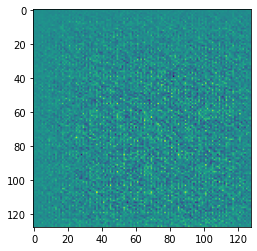

In [7]:
noise = tf.random.normal([1,SEED_SIZE])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

image_shape = (HEIGHT, HEIGHT, IMAGE_CHANNELS)

print(discriminator(generated_image))


In [8]:
def generate_images(generated_images2):
    fig = plt.figure(figsize=(10,10))
    for i in range(1,21):
        fig.add_subplot(5,5,i)
        plt.imshow(generated_images2[i])
        plt.axis('off')
    plt.show()

In [9]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [10]:
from src.utils import image_dataset_from_directory
dir = "images/"

  # labels="inferred", label_mode="int"
train_ds = image_dataset_from_directory(dir,
  seed=123,
  label_mode=None
  ,image_size=(128, 128), color_mode= "rgb",
  batch_size=BATCH_SIZE)

Found 8118 files belonging to 49 classes.


In [11]:
def process(image):
  image = tf.cast((image -127.5)/127.5 ,tf.float32)
  return image

train_ds = train_ds.map(process)
train_ds

<MapDataset shapes: (None, 128, 128, 3), types: tf.float32>

In [12]:
# https://keras.io/guides/writing_a_training_loop_from_scratch/
class GAN():
  def __init__(self):
    the_disc = Discriminator()
    the_gen = Generator()

    self.generator = the_gen.define_generator_model()
    self.generator_optimizer = the_gen.generator_opt()
    self.generator_losses = []

    self.discriminator = the_disc.define_discriminator_model()
    self.discriminator_optimizer = the_disc.discriminator_opt()
    self.discriminator_losses = []

    noise = Input(shape=(100,))
    img = self.generator(noise)
    valid, _ = self.discriminator(img)
    self.combined = Model(noise, valid)
    self.combined_opt = Adam(0.0002, 0.5)
    self.combined.compile(loss=['binary_crossentropy'], optimizer=self.combined_opt)

    self.accuracy = []

  @tf.function
  def train_step(self, images, batch_size):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      images_90 = tf.image.rot90(images, k=1)
      images_180 = tf.image.rot90(images, k=2)
      images_270 = tf.image.rot90(images, k=3)
      
      combined_images = tf.concat([images, images_90, images_180, images_270], axis=0)

      generated_images = self.generator(noise, training=True)
      real_output, _  = self.discriminator(combined_images, training=True)
      fake_output, _  = self.discriminator(generated_images, training=True)
      
      gen_loss = Generator().generator_loss(fake_output)
      disc_loss = Discriminator().discriminator_loss(real_output, fake_output)
      
      real_acc, fake_acc = Discriminator().discriminator_accuracy(real_output, fake_output)

    real_acc, fake_acc = Discriminator().discriminator_accuracy(real_output, fake_output)
  
    gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
    
    self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
    self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

    return gen_loss , disc_loss , generated_images, real_acc, fake_acc

  def train(self, epochs, batch_size, X=None, y=None, display_iter=10):
    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []
        start = time.time()

        for image_batch in (X):
            t =  self.train_step(image_batch, batch_size)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])
        
        g_loss = sum(gen_loss_list) / len(gen_loss_list) #calculate losses
        d_loss = sum(disc_loss_list) / len(disc_loss_list)
        
        acc = (t[3] + t[4]) * 0.5
        self.accuracy.append(acc)

        generate_images(t[2])
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
        print(f'Epoch {epoch+1}, gen loss = {g_loss}, disc loss = {d_loss},acc = {acc}')
        self.generator_losses.append(g_loss)
        self.discriminator_losses.append(d_loss)

    
  # Generate after the final epoch
  display.clear_output(wait=True)

In [13]:
gan = GAN()

In [14]:
gan.generator = load_model('trained_models' + '/generator.h5')
gan.discriminator = load_model('trained_models' + '/discriminator.h5')
gan.combined = load_model('trained_models' + '/combined.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

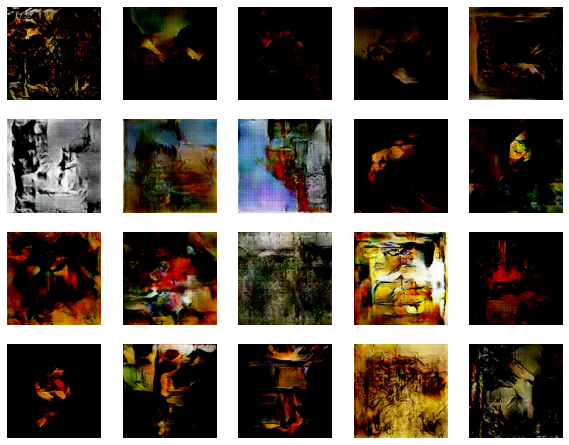

Time for epoch 1 is 34.41135001182556 sec
Epoch 1, gen loss = 7.946750640869141, disc loss = 0.18610022962093353,acc = 0.9898726940155029


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

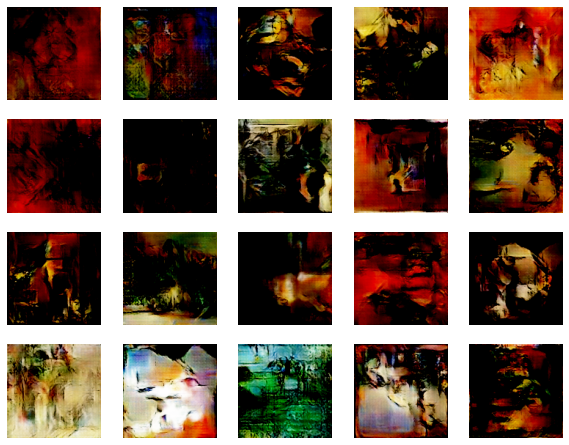

Time for epoch 2 is 33.10214924812317 sec
Epoch 2, gen loss = 8.130611419677734, disc loss = 0.2045753300189972,acc = 0.8339120149612427


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

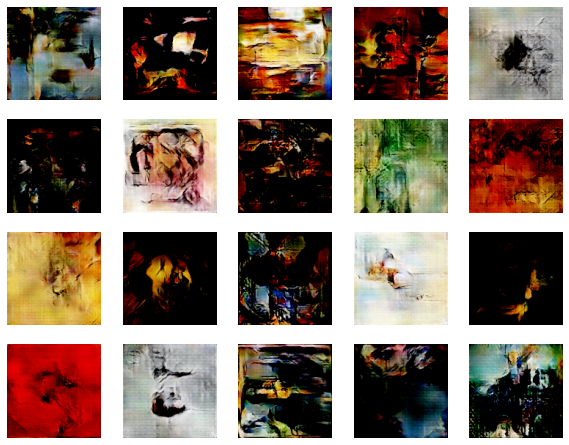

Time for epoch 3 is 32.721800565719604 sec
Epoch 3, gen loss = 7.631141662597656, disc loss = 0.1660373955965042,acc = 0.9791666269302368


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

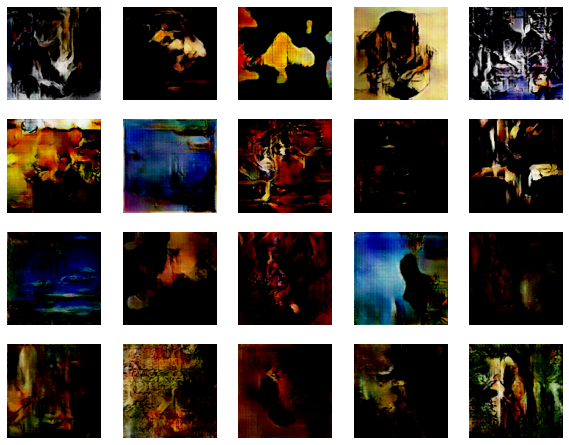

Time for epoch 4 is 33.0010666847229 sec
Epoch 4, gen loss = 7.542459964752197, disc loss = 0.24759532511234283,acc = 0.9651330709457397


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

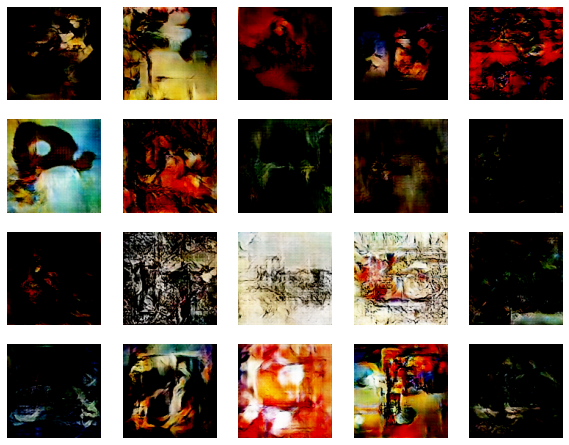

Time for epoch 5 is 33.246288537979126 sec
Epoch 5, gen loss = 8.03419303894043, disc loss = 0.1654912382364273,acc = 0.9589120149612427


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

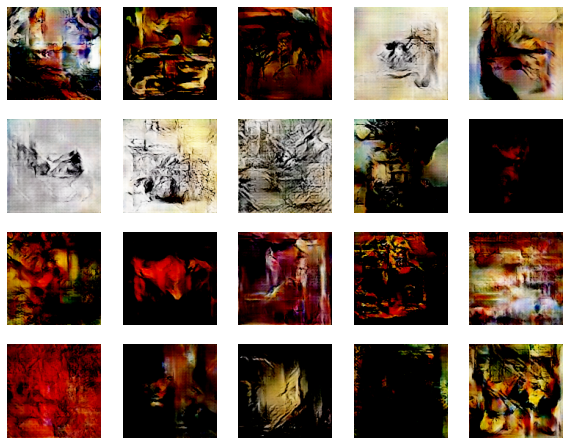

Time for epoch 6 is 32.943012714385986 sec
Epoch 6, gen loss = 8.358537673950195, disc loss = 0.14472445845603943,acc = 0.9657118320465088


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

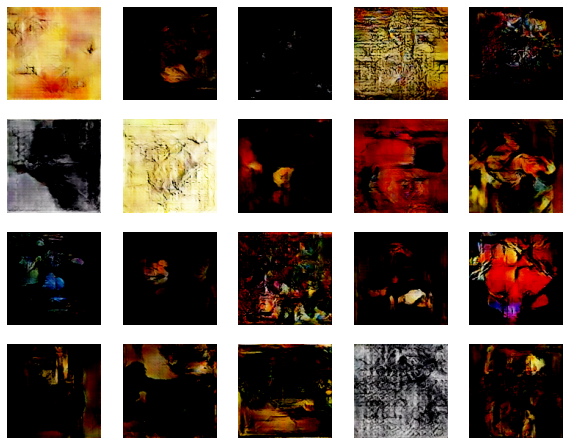

Time for epoch 7 is 33.140191316604614 sec
Epoch 7, gen loss = 8.334094047546387, disc loss = 0.16501547396183014,acc = 0.9458912014961243


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

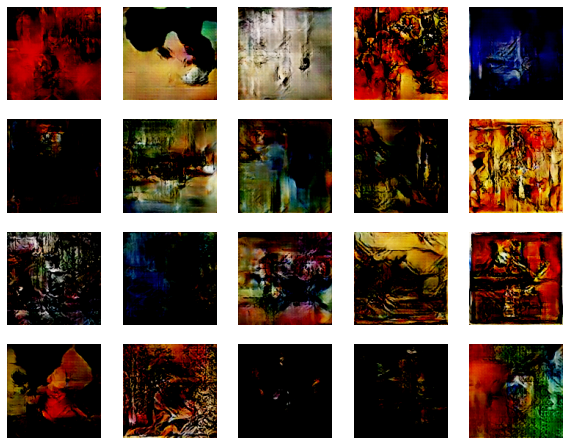

Time for epoch 8 is 33.207253217697144 sec
Epoch 8, gen loss = 7.2421135902404785, disc loss = 0.3115326464176178,acc = 0.9774305820465088


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

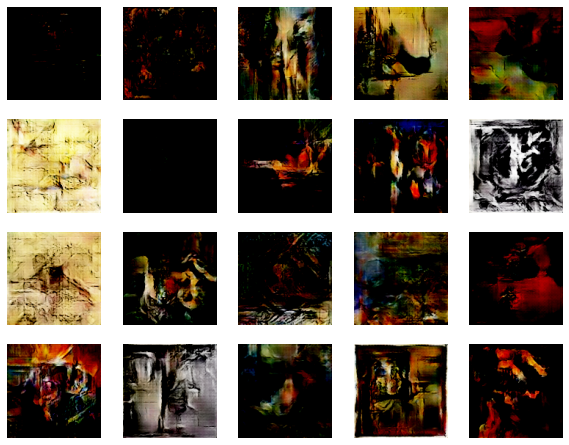

Time for epoch 9 is 33.499510765075684 sec
Epoch 9, gen loss = 7.828132629394531, disc loss = 0.144720196723938,acc = 0.96484375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

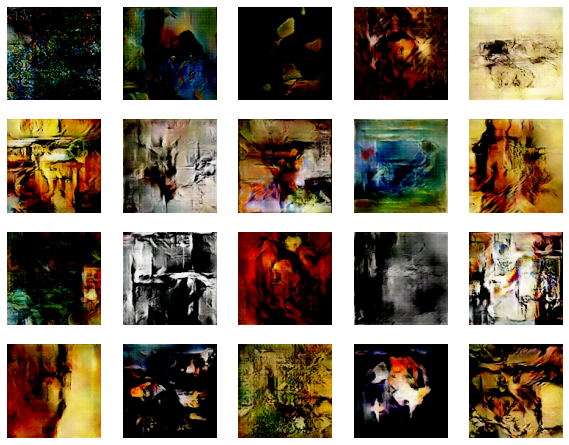

Time for epoch 10 is 33.252286195755005 sec
Epoch 10, gen loss = 6.211796760559082, disc loss = 0.3621552586555481,acc = 0.9696180820465088


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

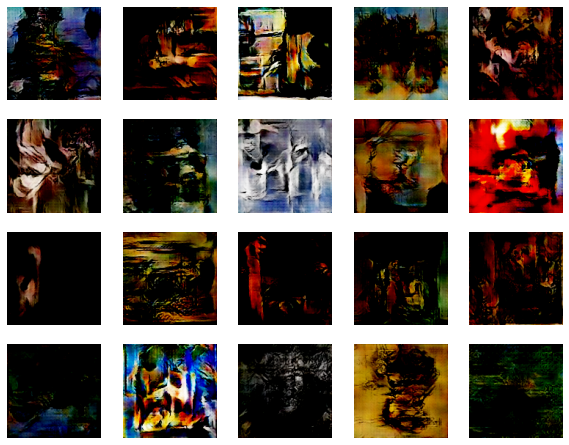

Time for epoch 11 is 33.534550189971924 sec
Epoch 11, gen loss = 8.094712257385254, disc loss = 0.16989122331142426,acc = 0.9441550970077515


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

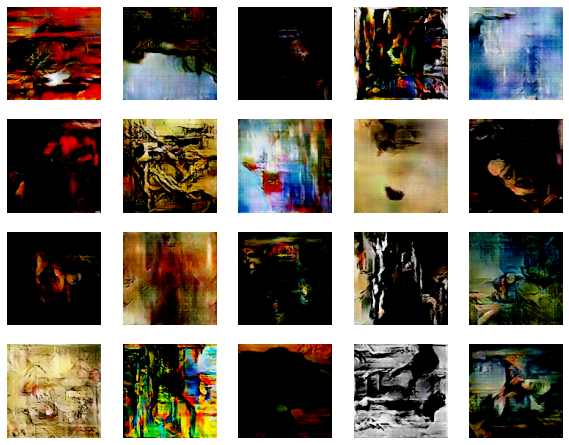

Time for epoch 12 is 33.39742636680603 sec
Epoch 12, gen loss = 7.913445949554443, disc loss = 0.1730765402317047,acc = 0.9898726940155029


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

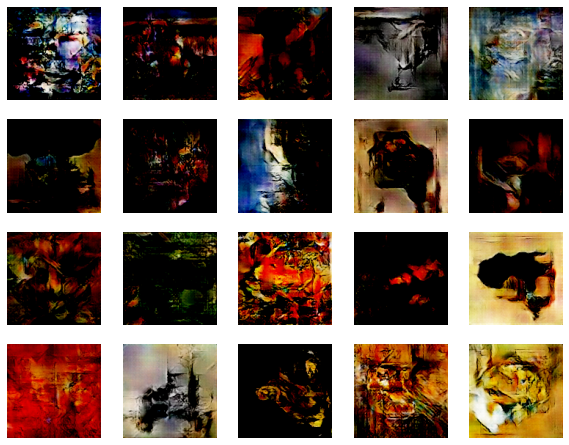

Time for epoch 13 is 33.39041066169739 sec
Epoch 13, gen loss = 8.190594673156738, disc loss = 0.1658729761838913,acc = 0.9589120149612427


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

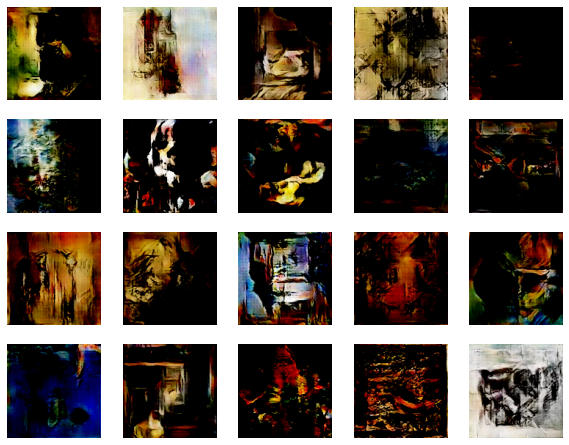

Time for epoch 14 is 33.40643548965454 sec
Epoch 14, gen loss = 7.917196750640869, disc loss = 0.20989374816417694,acc = 0.9836516380310059


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

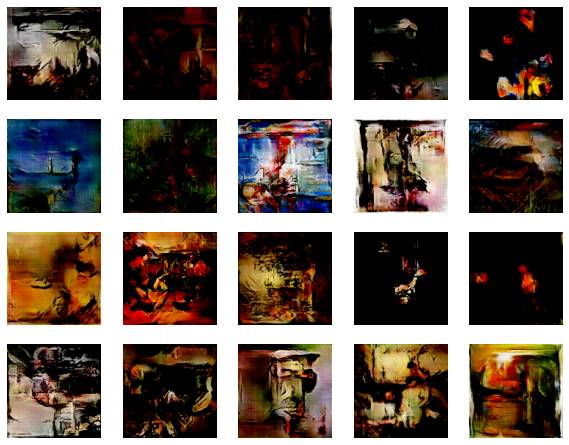

Time for epoch 15 is 33.30634260177612 sec
Epoch 15, gen loss = 8.096022605895996, disc loss = 0.17182672023773193,acc = 0.9767072200775146


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

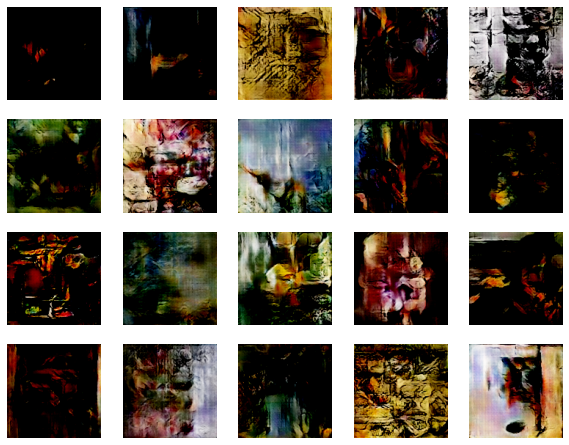

Time for epoch 16 is 33.391411781311035 sec
Epoch 16, gen loss = 7.7716217041015625, disc loss = 0.20580559968948364,acc = 0.9605034589767456


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

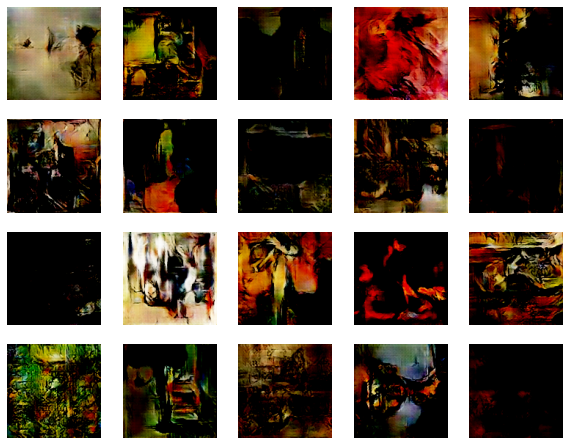

Time for epoch 17 is 33.32636213302612 sec
Epoch 17, gen loss = 8.137683868408203, disc loss = 0.15403853356838226,acc = 0.9719328880310059


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

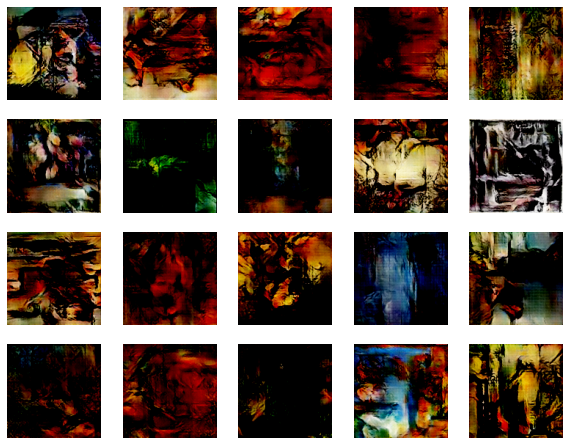

Time for epoch 18 is 33.51652550697327 sec
Epoch 18, gen loss = 8.408114433288574, disc loss = 0.15231256186962128,acc = 0.9820601940155029


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

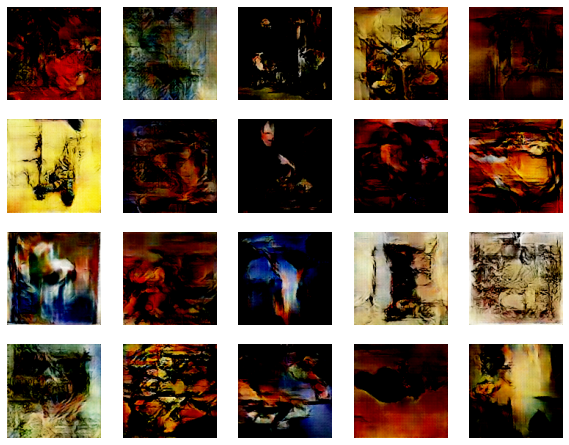

Time for epoch 19 is 33.45747995376587 sec
Epoch 19, gen loss = 8.337682723999023, disc loss = 0.15641318261623383,acc = 0.9859664440155029


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

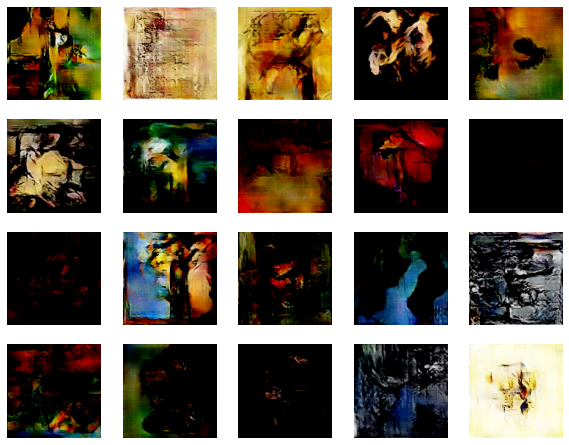

Time for epoch 20 is 34.04901075363159 sec
Epoch 20, gen loss = 8.138320922851562, disc loss = 0.17017513513565063,acc = 0.9767072200775146


In [15]:
gan.train(X=train_ds, y=train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, display_iter=2)


In [ ]:
gan.generator.save('trained_models/generator.h5')
gan.discriminator.save('trained_models/discriminator.h5')
gan.combined.save('trained_models/combined.h5')

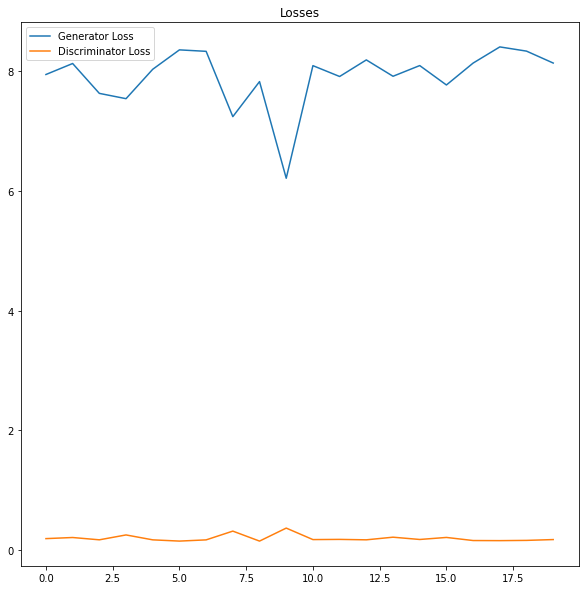

In [19]:
fig = plt.figure(figsize=(10,10))
plt.plot(range(EPOCHS) ,gan.generator_losses, label="Generator Loss")
plt.plot(range(EPOCHS) ,gan.discriminator_losses, label="Discriminator Loss")
plt.legend()
plt.title('Losses')
plt.show()

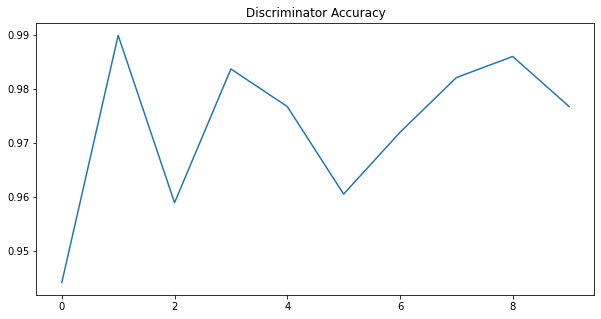

In [26]:
fig = plt.figure(figsize=(10,5))
plt.plot((range(EPOCHS)[:-10]) ,gan.accuracy[-10:], label="Accuracy")
plt.title('Discriminator Accuracy')
plt.show()